In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import healpy as hp
import sqlite3
import rubin_sim.maf as maf
from rubin_sim.phot_utils import DustValues
from rubin_sim.scheduler.utils import EuclidOverlapFootprint, generate_all_sky

In [2]:
# Identify simulation and location on disk
opsdb_file = '/Users/lynnej/opsim/fbs_3.3/baseline_v3.3_10yrs.db'
opsdb_name = os.path.split(opsdb_file)[-1].replace('.db', '')
print("Using", opsdb_name, "at", opsdb_file)

Using baseline_v3.3_10yrs at /Users/lynnej/opsim/fbs_3.3/baseline_v3.3_10yrs.db


In [3]:
!ls $opsdb_file

/Users/lynnej/opsim/fbs_3.3/baseline_v3.3_10yrs.db


In [4]:
dust = DustValues()
pd.DataFrame(dust.r_x, index=['R_x/A_v values']).round(2)

,u,g,r,i,z,y
R_x/A_v values,4.76,3.66,2.7,2.05,1.59,1.31


In [5]:
# What information can you get from the opsim output itself, regarding *how* a particular visit was obtained (in what mode)
conn = sqlite3.connect(opsdb_file)
query = "select distinct(note) from observations"
pd.read_sql(query, conn)

,note
0,"blob_long, gr, a"
1,"blob_long, gr, b"
2,"pair_33, ug, a"
3,"pair_33, ug, b"
4,long
5,greedy
6,"twilight_near_sun, 0"
7,"twilight_near_sun, 1"
8,"twilight_near_sun, 2"
9,"twilight_near_sun, 3"


Some of the above 'note' information is straightforward -- "DD:ELAIS1" for example is a DD field, and visits labelled like this were taken in a sequence specifically for the DDF (note that there will also be "typical WFD-style" visits at that point on the sky too). 
Some is not immediately obvious but clear if you know some extra information .. "blob_long" and "long" visits are visits that are part of the triplet sets (see SCOC recommendations to occasionally take triplets of visits in a night, for better sub-night time sampling) .. 'blob_long' are the first pair, 'long' is the more separated triplet visit. "twilight_near_sun" visits are part of the near-sun twilight visits taken at high airmass to find near-sun objects. 

"greedy" are the simplest twilight visits, taken basically as a time-filler .. these are scheduled as 'the next best visit to take' only, instead of as blocks/blobs. They are single visits, not pairs.

"pair_15" are standard survey visits taken during twilight .. the interval is 15 minutes instead of the standard 33, because we need to finish the twilight visit block before twilight is done. 

"pair_33" are the standard survey pair visits. You can see which pair of filters is in each pair by the name (see iz paired, as well as zy .. as well as yy). "a" or "b" indicates whether the visit was in the first pass of a pair or the second. 

['' 'LMC_SMC' 'bulgy' 'dusty_plane' 'euclid_overlap' 'lowdust' 'nes' 'scp'
 'virgo']


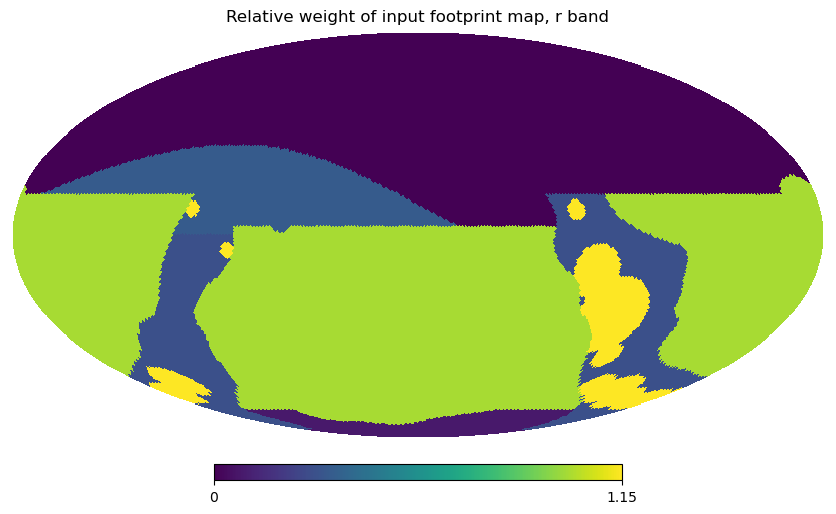

In [6]:
# You can also get some information from the input footprint .. 
# but it's worth noting here that different regions do not overlap here (yet in the output, near-sun-twilight visits overlap WFD, etc.).
nside = 64
sky = EuclidOverlapFootprint(nside=nside)
footprint_map, labels = sky.return_maps()

print(np.unique(labels))
hp.mollview(footprint_map['r'], title='Relative weight of input footprint map, r band')

The "labels" above is a numpy array of the same length as each of the filters in the footprint_map dictionary .. so footprint_map['r'] is a numpy array with a value for each healpix on the sky, indicating the relative weight that should be given to this part of the footprint in the sky, while "labels" tells how the weights were decided for each of these pixels in the array. 

As an example --the "LMC_SMC" label indicates the pixels/region of the sky intended to cover the LMC and SMC, and by selecting those pixels in the 'labels' array you can see the relevant weights in the footprint. 

* "lowdust" -- the low-dust-extinction WFD area. 
* "nes" -- the North Ecliptic Spur area. 
* "scp" -- the South Celestial Pole area.
* "bulgy" -- the higher dust-extinction WFD area within the galactic plane.
* "dusty_plane" -- the higher dust-extinction coverage area within the galactic plane.
* "LMC_SMC" -- the LMC and SMC WFD-level coverage.
* "euclid_overlap" -- a (very small) low-dust-extinction WFD area at low declination.
* "virgo" -- a (very small) low-dust-extinction WFD area at high declination.

Note that the DDFs do not appear in this footprint map! They are written into the scheduler separately, as focused 'scripted' surveys. Parts of the sky in the list above which include "WFD area" in their description are covered with WFD-level number of visits .. on the order of 800 visits per pointing. Parts of the sky which do not include "WFD area" are covered to a few hundred visits per pointing, depending on the specific region. 

Filter balance can vary between different regions. 

In [7]:
# Set up a custom HealpixSubsetSlicer, using dust extinction definition and ra/dec limits 
# easiest way to do this is to grab this information from an all-purpose sky footprint util we have ..
# (it generates arrays with ra/dec/galactic lat/long 
# and also jam the dustmap from the EuclidOverlapFootprint in too .. 

allsky = generate_all_sky(nside=nside)
allsky['ebv'] = sky.dustmap.copy()
allsky

{'map': array([-1.6375e+30, -1.6375e+30, -1.6375e+30, ...,  0.0000e+00,
         0.0000e+00,  0.0000e+00]),
 'ra': array([ 45., 135., 225., ..., 135., 225., 315.]),
 'dec': array([ 89.26902929,  89.26902929,  89.26902929, ..., -89.26902929,
        -89.26902929, -89.26902929]),
 'eclip_lat': array([ 66.03858367,  66.03858393,  67.07209479, ..., -67.07209451,
        -66.03858367, -66.03858393]),
 'eclip_lon': array([ 88.72333948,  91.26889798,  91.32297365, ..., 268.66926248,
        268.72333948, 271.26889798]),
 'gal_lat': array([ 26.50863827,  27.51540064,  27.74651416, ..., -26.7376784 ,
        -26.50863827, -27.51540064]),
 'gal_lon': array([123.36647898, 123.6298103 , 122.49253442, ..., 302.23887681,
        303.36647898, 303.6298103 ]),
 'ebv': array([0.28748405, 0.26713541, 0.19383599, ..., 0.142555  , 0.14455602,
        0.15124393])}

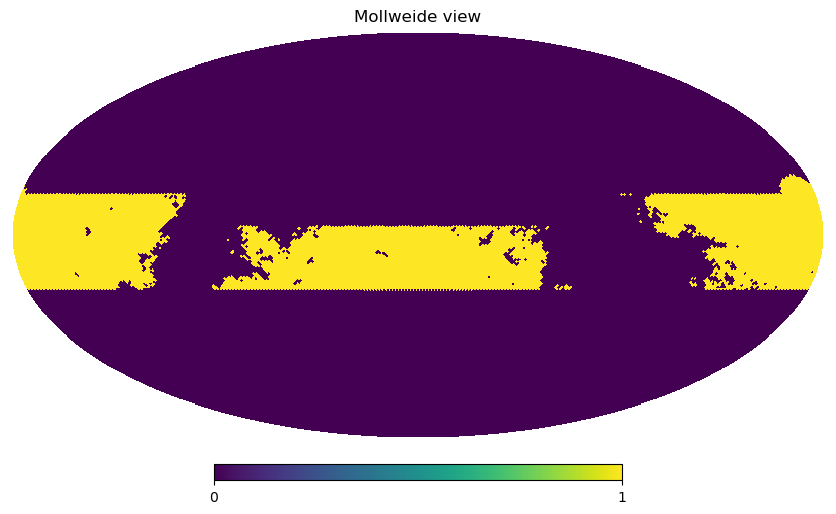

In [8]:
# Each of these arrays is the same length and corresponds to the proper order for a healpix array .. 
# We can thus identify subsets of healpix pixels by what matches in this set, then set up our HealpixSubsetSlicer.

hp_good = ((allsky['dec'] > -20) & (allsky['ebv'] < 0.1))

# I suspect you may want to remove the NES region, as there is *no* u band imaging there .. 

hp_good = hp_good & (labels != 'nes')

# and why not just remove the rest of the sky which isn't covered at all 

hp_good = hp_good & (labels != '')

hp.mollview(hp_good)

In [9]:
slicer = maf.HealpixSubsetSlicer(nside, np.where(hp_good)[0], use_cache=False)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [10]:
bundles = {}
metric = maf.ExgalM5()

summary_metrics = maf.extended_summary()  # Note you could add extra values here .. 
summary_metrics += [maf.PercentileMetric(col='metric_data', percentile=10, metric_name='10th%ile')]

#slicer = maf.HealpixSlicer(nside)
for f in 'ugri':
    for yr in [1, 2]:
        # It turned out I could see the DDFs in the year 1 u band plot, so skip those too here 
        bundles[f"{f} yr {yr}"] = maf.MetricBundle(metric, slicer, 
                                                   constraint=f"filter == '{f}' and night < 365*{yr} and note not like '%DD%'",
                                                   run_name=opsdb_name, info_label=f"{f} band year {yr}", 
                                                   summary_metrics=summary_metrics)

In [11]:
out_dir = 'temp'
results_db = maf.ResultsDb(out_dir)
g = maf.MetricBundleGroup(bundles, opsdb_file, out_dir=out_dir, results_db=results_db)
g.run_all()

/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


In [12]:
pd.DataFrame([bundles[b].summary_values for b in bundles], index=[b for b in bundles])

,Mean,Rms,Median,Max,Min,N(+3Sigma),N(-3Sigma),Count,25th%ile,75th%ile,10th%ile
u yr 1,24.080707,0.287298,24.089251,24.824430,22.364507,0,36,8427,23.892450,24.288914,23.714412
u yr 2,24.266255,0.246009,24.263918,24.934288,22.582760,0,15,8429,24.099682,24.438519,23.952262
g yr 1,25.426484,0.259521,25.424340,26.160358,23.292105,0,36,8430,25.256907,25.610466,25.102237
g yr 2,25.775015,0.248139,25.789540,26.435440,24.533677,0,21,8430,25.606107,25.961153,25.439119
r yr 1,25.637066,0.165478,25.649049,26.114085,24.935344,0,34,8430,25.528495,25.756703,25.416331
r yr 2,25.967018,0.209964,25.999049,26.433737,24.983466,0,26,8430,25.838526,26.125761,25.657963
i yr 1,25.255911,0.153793,25.268914,25.690426,24.499607,0,34,8430,25.154215,25.367201,25.050436
i yr 2,25.579165,0.203475,25.615328,26.074322,24.692914,0,36,8430,25.472988,25.724154,25.272620


In [13]:
# Set up a plot handler so we save figures to disk in out_dir with format fig_format.
ph = maf.PlotHandler(out_dir=out_dir, fig_format='png', thumbnail=False)

2

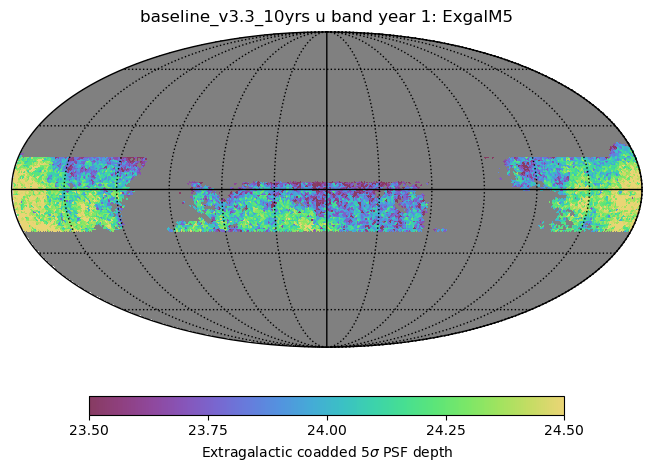

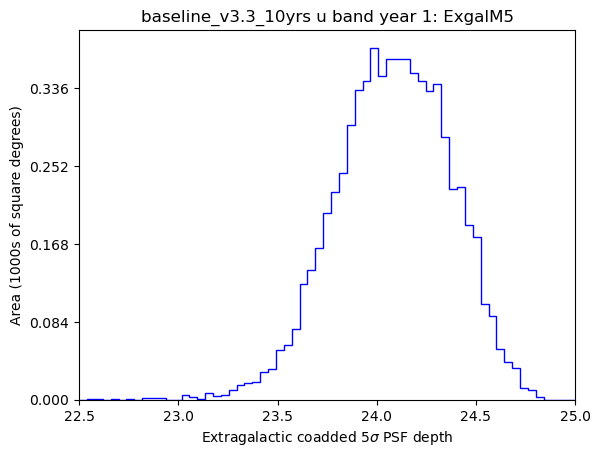

In [14]:
ph.set_metric_bundles([bundles['u yr 1']])
plot_dict = {'xlabel': "Extragalactic coadded $5\sigma$ PSF depth",
             'color_min': 23.5, 'color_max': 24.5, 'n_ticks': 4,
            'x_min': 22.5, 'x_max': 25}
ph.plot(maf.HealpixSkyMap(), plot_dicts=plot_dict)
ph.plot(maf.HealpixHistogram(), plot_dicts=plot_dict)

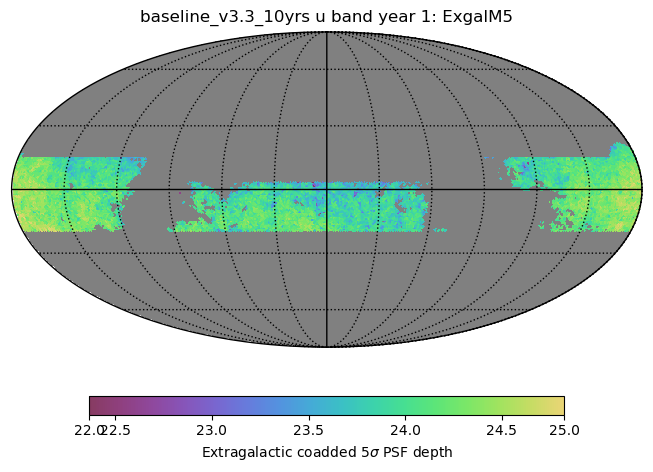

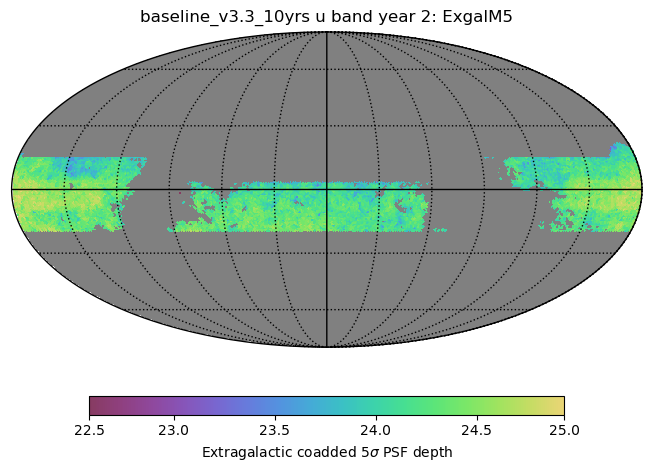

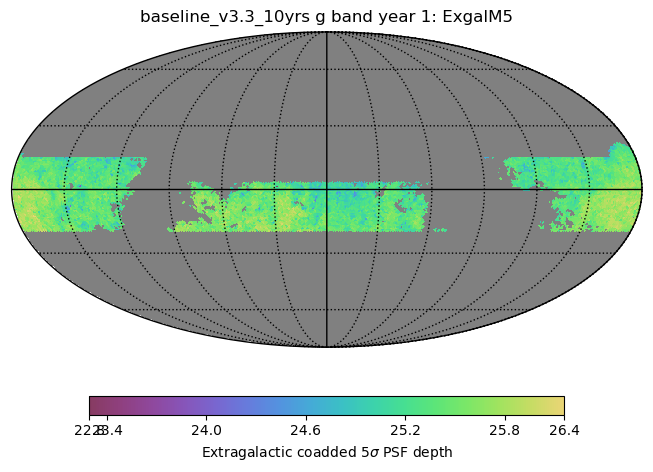

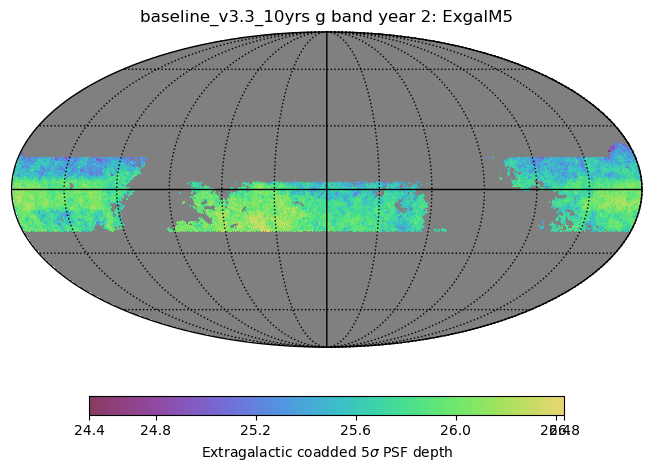

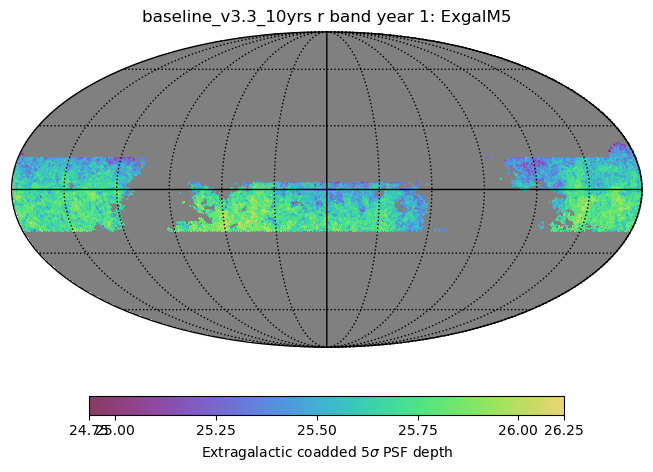

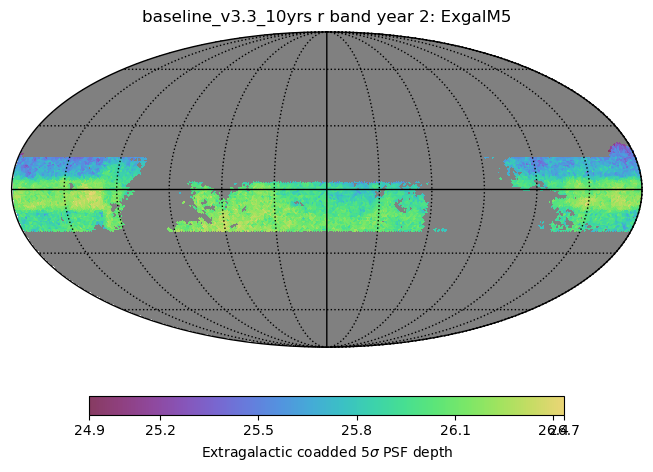

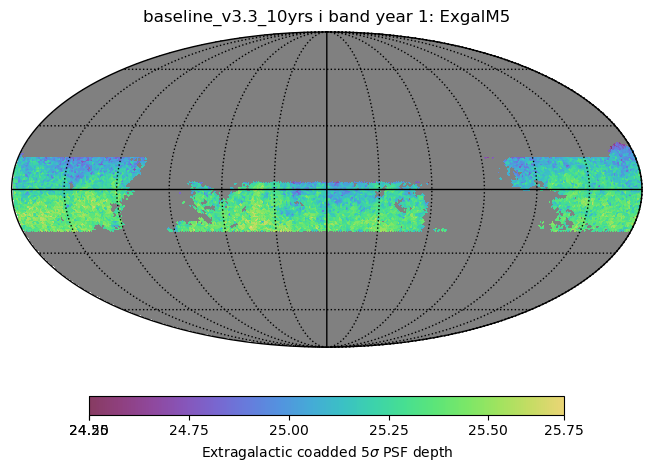

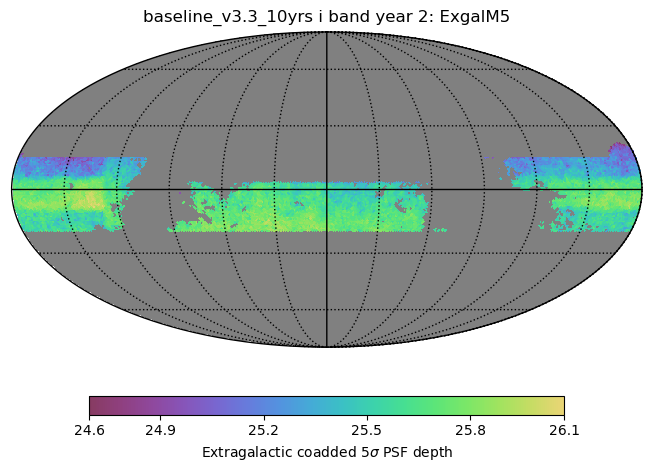

In [15]:
for b in bundles:
    ph.set_metric_bundles([bundles[b]])
    plot_dict = {'xlabel': "Extragalactic coadded $5\sigma$ PSF depth",
                 'n_ticks': 5}
    ph.plot(maf.HealpixSkyMap(), plot_dicts=plot_dict)
    #ph.plot(maf.HealpixHistogram(), plot_dicts=plot_dict)

Might be worth noting that you can start to see the effect of the rolling cadence by the year 2 plots. This is stronger in r and i bands, because rolling is effectively stronger in those bands (because there are more visits in those bands, so there are more to redistribute between years). 

You could consider using the outputs of these coadded maps to go back and tweak the input healpix subset slicer. 
Or you could sub-class the ExgalM5 metric so that visits which have individual image depths far from the usual (or really bad seeing, or so on) are rejected -- but only if that is likely to mean rejecting input data. 

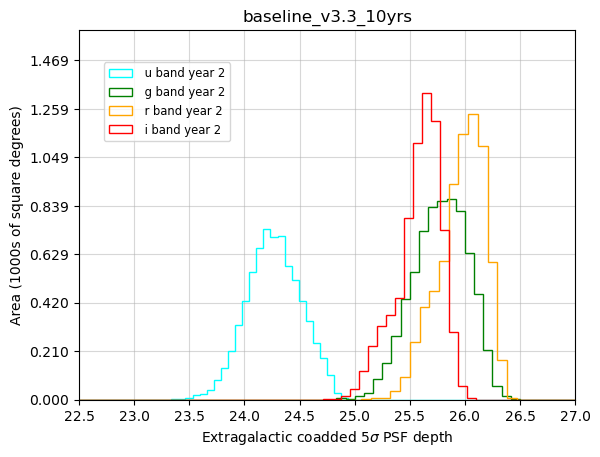

In [16]:
colors = {"u": "cyan", "g": "g", "r": "orange", "i": "r", "z": "m", "y": "b"}
for f in 'ugri':
    for yr in [1, 2]:
        bundles[f"{f} yr {yr}"].set_plot_dict({'color': colors[f]})

ph.set_metric_bundles([bundles[b] for b in bundles if 'yr 2' in b])
plot_dict = {'title': f"{opsdb_name}",
             'xlabel': "Extragalactic coadded $5\sigma$ PSF depth",
            'x_min': 22.5, 'x_max': 27, 
             'y_min': 0, 'y_max': 1.6*1000/hp.nside2pixarea(nside, degrees=True),
             'legend_loc': (0.05, 0.7)}
ph.plot(maf.HealpixHistogram(), plot_dicts=plot_dict)
plt.grid(True, alpha=0.5)